## Neural Network Analysis

#### Imports

In [1]:
from pandas import read_csv
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM ,GRU
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers

import random

random.seed(11)


2023-04-23 23:05:08.013166: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
df = read_csv("../_data/hasbro_stock.csv", engine='python')
print(df)
X = np.array(df['adjusted'].values.astype('float32')).reshape(df.shape[0],1)
print(X.shape)

            date     volume   adjusted
0     2019-01-02  1759000.0  69.933632
1     2019-01-03  1472700.0  68.114883
2     2019-01-04  2072400.0  70.641869
3     2019-01-07  1951600.0  72.827858
4     2019-01-08  1888100.0  74.681572
...          ...        ...        ...
1003  2022-12-23  1146300.0  57.518669
1004  2022-12-27   917800.0  58.131310
1005  2022-12-28  1068200.0  57.528553
1006  2022-12-29  1603800.0  60.265656
1007  2022-12-30  1274000.0  60.285416

[1008 rows x 3 columns]
(1008, 1)


#### Data Prep

In [3]:
# Parameter split_percent defines the ratio of training examples
def get_train_test(data, split_percent=0.8):
    scaler = MinMaxScaler(feature_range=(0, 1))
    data = scaler.fit_transform(data).flatten()
    n = len(data)
    # Point for splitting data into train and test
    split = int(n*split_percent)
    train_data = data[range(split)]
    test_data = data[split:]
    return train_data, test_data, data

train_data, test_data, data = get_train_test(X)

print(train_data.shape)
print(test_data.shape)

(806,)
(202,)


In [4]:
# PREPARE THE INPUT X AND TARGET Y
def get_XY(dat, time_steps,plot_data_partition=False):
    global X_ind,X,Y_ind,Y #use for plotting later

    # INDICES OF TARGET ARRAY
    # Y_ind [  12   24   36   48 ..]; print(np.arange(1,12,1)); exit()
    Y_ind = np.arange(time_steps, len(dat), time_steps); #print(Y_ind); exit()
    Y = dat[Y_ind]

    # PREPARE X
    rows_x = len(Y)
    X_ind=[*range(time_steps*rows_x)]
    del X_ind[::time_steps] #if time_steps=10 remove every 10th entry
    X = dat[X_ind]; 

    #PLOT
    if(plot_data_partition):
        plt.figure(figsize=(15, 6), dpi=80)
        plt.plot(Y_ind, Y,'o',X_ind, X,'-'); plt.show(); 

    #RESHAPE INTO KERAS FORMAT
    X1 = np.reshape(X, (rows_x, time_steps-1, 1))
    # print([*X_ind]); print(X1); print(X1.shape,Y.shape); exit()

    return X1, Y


#PARTITION DATA
p=6 # simpilar to AR(p) given time_steps data points, predict time_steps+1 point (make prediction one month in future)

testX, testY = get_XY(test_data, p)
trainX, trainY = get_XY(train_data, p)

In [5]:
print(testX.shape,testY.shape)
print(trainX.shape,trainY.shape)
print(type(trainX))

(33, 5, 1) (33,)
(134, 5, 1) (134,)
<class 'numpy.ndarray'>


In [6]:
import plotly.io as pio
pio.renderers.default = "plotly_mimetype+notebook_connected"
import plotly.express as px

# UTILITY
def plotly_line_plot(t,y,title="Plot",x_label="t: time (months)",y_label="y(t): Response variable"):

    # GENERATE PLOTLY FIGURE
    fig = px.line(x=t[0],y=y[0], title=title, render_mode='SVG')  
    # IMPORTANT: SVG FIXES RENDER ISSUES WITH SAD FACE 
    # https://community.plotly.com/t/plotly-express-line-charts-are-not-shown/39715
    
    # ADD MORE
    for i in range(1,len(y)):
        if len(t[i])==1:
            #print(t[i],y[i])
            fig.add_scatter(x=t[i],y=y[i])
        else:
            fig.add_scatter(x=t[i],y=y[i], mode='lines')

    fig.update_layout(
        xaxis_title=x_label,
        yaxis_title=y_label,
        template="plotly_white",
        showlegend=False
    )
    fig.show()

In [7]:
# SINGLE SERIES 
t1=[*range(0,len(train_data))]
t2=len(train_data)+np.array([*range(0,len(test_data))])
plotly_line_plot([t1,t2],[train_data,test_data],title="Hasbro Stock Price 2019-2022")

In [8]:
#USER PARAM
recurrent_hidden_units=3
epochs=200
f_batch=0.2    #fraction used for batch size
optimizer="RMSprop"
validation_split=0.2
print(trainX.shape,p,trainY.shape)

# trainY=trainY.reshape(trainY.shape[0],1)
# testY=testY.reshape(testY.shape[0],1)
print(p,trainX.shape,testX.shape,trainY.shape,testY.shape)

(134, 5, 1) 6 (134,)
6 (134, 5, 1) (33, 5, 1) (134,) (33,)


In [9]:
## Build list 
tmp1=[]; tmp2=[]; tmp3=[]; count=0
for i in range(0,trainX.shape[0]):
    # tmp1.append()
    tmp1.append(count+np.array([*range(0,trainX[i,:,0].shape[0])]))
    tmp1.append([count+trainX[i,:,0].shape[0]]); #print(([count+trainX[i,:,0].shape[0]]))
    # tmp1.append([count+trainX[i,:,0].shape[0]+1])
    tmp2.append(trainX[i,:,0])
    tmp2.append([trainY[i]]); #print([trainY[i]])
    # tmp2.append([trainY[i]])

    count+=trainX[i,:,0].shape[0]+1

    # print(i,trainX[i,:,0].shape)
# print(tmp1)
# print(tmp2)
plotly_line_plot(tmp1,tmp2,title="Hasbro Stock Price Partitions, 2019-2022")

# Define Functions for Building, Training, and Plotting Models

In [10]:
def createModel(model_name="", dropout=0, regularization=None):
    '''
    Takes in the name of a model and returns the compiled model.
    Accepts float value for dropout in the case of GRU models.
    Also accepts a regularization feature for all three models, example: regularizers.L2(1e-2)
    '''

    model = Sequential()
    
    if model_name == "rnn":
        model.add(SimpleRNN(
        recurrent_hidden_units,
        return_sequences=False,
        input_shape=(trainX.shape[1],trainX.shape[2]), 
        recurrent_regularizer=regularization,
        activation='tanh'))

    elif model_name == "gru":
        model.add(GRU(
        recurrent_hidden_units,
        return_sequences=False,
        input_shape=(trainX.shape[1],trainX.shape[2]), 
        recurrent_dropout=dropout,
        recurrent_regularizer=regularization,
        activation='tanh'))

    elif model_name == "lstm":
        model.add(LSTM(
        recurrent_hidden_units,
        return_sequences=False,
        input_shape=(trainX.shape[1],trainX.shape[2]), 
        recurrent_regularizer=regularization,
        activation='tanh'))

    else:
        print("Specify model as 'rnn', 'gru', or 'lstm'")
        exit()

    #NEED TO TAKE THE OUTPUT RNN AND CONVERT TO SCALAR 
    model.add(Dense(units=1, activation='linear'))

    # COMPILE THE MODEL 
    model.compile(loss='MeanSquaredError', optimizer=optimizer)
    model.summary()

    return model

In [11]:
#TRAIN MODEL
def train_model(model, verbose=0):
    '''
    Takes a model built through createModel() and trains for the epochs and batch_size
    set in the USER PARAM universal variables. Assumes trainX and trainY are also universal variables,
    since they are consistent for each model built.
    '''
    history = model.fit(
    trainX, trainY, 
    epochs=epochs, 
    batch_size=int(f_batch*trainX.shape[0]), 
    validation_split=validation_split,  # BEING "SLOPPY WITH CROSS VALIDATION" HERE FOR TIME-SERIES
    verbose=verbose)

    return model, history

In [12]:
def plot_history(model, history, model_name, regularization, plot="plotly"):

    if regularization != None:
        reg = " (with L2 Regularization)"
    else:
        reg = ""

    #HISTORY PLOT
    epochs_steps = [*range(0, len(history.history['loss']))]

    if plot == "plotly":
    # PLOTLY PLOT
        plotly_line_plot([epochs_steps,epochs_steps],[history.history['loss'],history.history['val_loss']],
        title=f"Hasbro Stock Price, 2019-2022, {model_name.upper()}{reg}",
        x_label="Training Epochs",
        y_label="Loss (MSE)")

    elif plot == "simple":
    # print(history.history['loss'])
    # SIMPLE PLOT 
        plt.figure()
        plt.plot(epochs_steps, history.history['loss'], 'bo', label='Training loss')
        plt.plot(epochs_steps, history.history['val_loss'], 'b', label='Validation loss')
        plt.legend()
    
    else:
        print("Specify plot as 'plotly' or 'simple'.")


In [13]:
def print_rsme(model):

    # MAKE PREDICTIONS
    train_predict = model.predict(trainX).squeeze()
    test_predict = model.predict(testX).squeeze()
    # print(trainX.shape, train_predict.shape,trainY.shape,testX.shape, test_predict.shape,testY.shape)  

    #COMPUTE RMSE
    # print(trainY.shape, train_predict.shape)
    train_rmse = np.sqrt(mean_squared_error(trainY, train_predict))
    test_rmse = np.sqrt(mean_squared_error(testY, test_predict))
    # print(np.mean((trainY-train_predict)**2.0))
    # print(np.mean((testY-test_predict)**2.0))

    print('Train MSE = %.5f RMSE = %.5f' % (train_rmse**2.0,train_rmse))
    print('Test MSE = %.5f RMSE = %.5f' % (test_rmse**2.0,test_rmse))  

In [14]:
# PLOT THE RESULT
def plot_result(model, trainY, testY):

    train_predict = model.predict(trainX).squeeze()
    test_predict = model.predict(testX).squeeze()

    plt.figure(figsize=(15, 6), dpi=80)
    #ORIGINAL DATA
    print(X.shape,Y.shape)
    plt.plot(Y_ind, Y,'o', label='target')
    plt.plot(X_ind, X,'.', label='training points');     
    plt.plot(Y_ind, train_predict,'r.', label='prediction');    
    plt.plot(Y_ind, train_predict,'-');    
    plt.legend()
    plt.xlabel('Observation number after given time steps')
    plt.ylabel('Hasbro Stock Price scaled')
    plt.title('Actual and Predicted Values')
    plt.show()

In [15]:
def modelProcess(model_name="", dropout=0, regularization=None, verbose=0):
    '''
    Create a pipeline of functions to call for creating a model, training it,
    plotting the error term over each epoch, printing the error term, and then
    plotting the actual and predicted values for model evaluation.
    '''
    print("")
    createdModel = createModel(model_name, dropout, regularization)
    print("")
    trainedModel, history = train_model(createdModel, verbose)
    print("")
    plot_history(trainedModel, history, model_name, regularization)
    print("")
    print_rsme(trainedModel)
    print("")
    plot_result(trainedModel, trainY, testY)

# 1) RNN w/o Regularization


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 3)                 15        
                                                                 
 dense (Dense)               (None, 1)                 4         
                                                                 
Total params: 19
Trainable params: 19
Non-trainable params: 0
_________________________________________________________________





2/2 [==============================] - 0s 2ms/step
Train MSE = 0.00109 RMSE = 0.03303
Test MSE = 0.00100 RMSE = 0.03158

2/2 [==============================] - 0s 2ms/step
(670,) (134,)


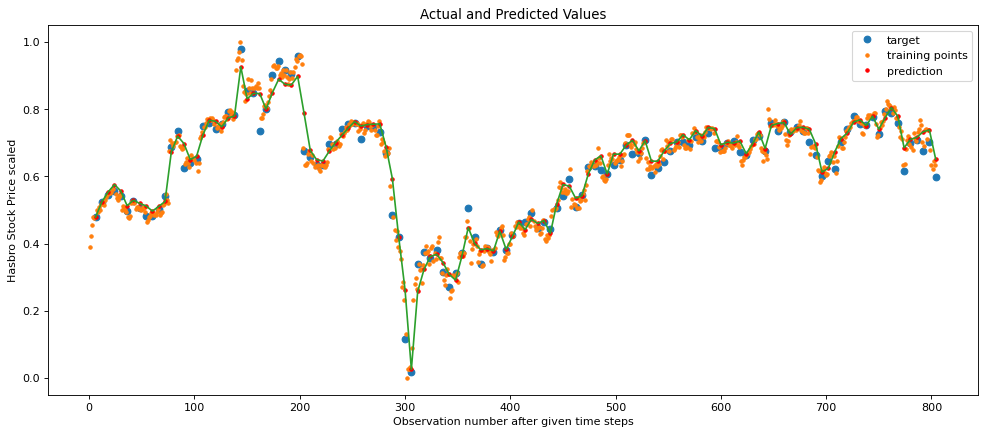

In [16]:
modelProcess(model_name="rnn",
             dropout=None,
             regularization=None,
             verbose=0)

# 2) RNN w/ Regularization


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 3)                 15        
                                                                 
 dense_1 (Dense)             (None, 1)                 4         
                                                                 
Total params: 19
Trainable params: 19
Non-trainable params: 0
_________________________________________________________________





2/2 [==============================] - 0s 2ms/step
Train MSE = 0.00080 RMSE = 0.02831
Test MSE = 0.00066 RMSE = 0.02568

2/2 [==============================] - 0s 2ms/step
(670,) (134,)


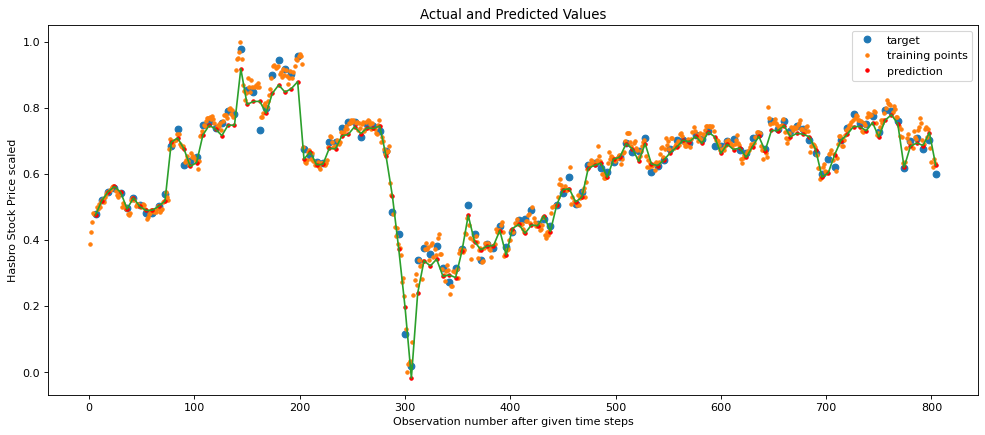

In [17]:
modelProcess(model_name = "rnn", 
             dropout = None, 
             regularization = regularizers.L2(1e-2), 
             verbose=0)

# 3) GRU w/o Regularization


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 3)                 54        
                                                                 
 dense_2 (Dense)             (None, 1)                 4         
                                                                 
Total params: 58
Trainable params: 58
Non-trainable params: 0
_________________________________________________________________





2/2 [==============================] - 0s 4ms/step
Train MSE = 0.00085 RMSE = 0.02908
Test MSE = 0.00074 RMSE = 0.02713

2/2 [==============================] - 0s 3ms/step
(670,) (134,)


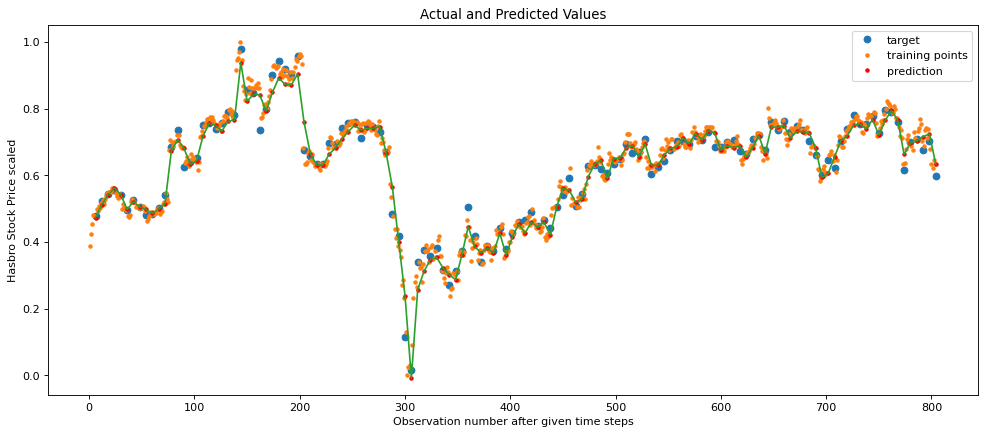

In [18]:
modelProcess(model_name="gru",
             dropout=0.8,
             regularization=None,
             verbose=0)

# 4) GRU w/ Regularization


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_1 (GRU)                 (None, 3)                 54        
                                                                 
 dense_3 (Dense)             (None, 1)                 4         
                                                                 
Total params: 58
Trainable params: 58
Non-trainable params: 0
_________________________________________________________________





2/2 [==============================] - 0s 3ms/step
Train MSE = 0.00082 RMSE = 0.02871
Test MSE = 0.00087 RMSE = 0.02954

2/2 [==============================] - 0s 2ms/step
(670,) (134,)


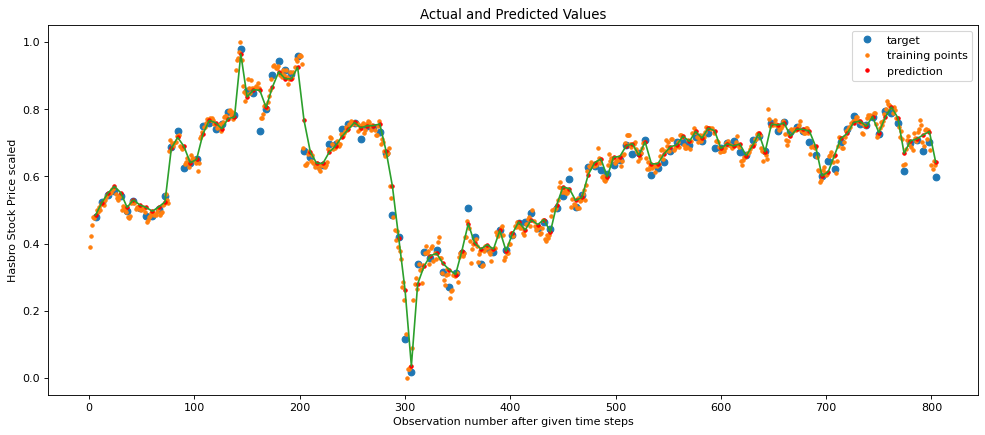

In [19]:
modelProcess(model_name="gru",
             dropout=0.8,
             regularization=regularizers.L2(1e-2),
             verbose=0)

# 5) LSTM w/o Regularization


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 3)                 60        
                                                                 
 dense_4 (Dense)             (None, 1)                 4         
                                                                 
Total params: 64
Trainable params: 64
Non-trainable params: 0
_________________________________________________________________


2023-04-23 23:05:52.542267: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-23 23:05:52.544120: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-23 23:05:52.545356: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2023-04-23 23:05:52.824356: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-23 23:05:52.825977: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-23 23:05:52.827156: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus


5/5 [==============================] - 0s 2ms/step


2023-04-23 23:06:01.995834: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-23 23:06:01.997343: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-23 23:06:01.998483: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2/2 [==============================] - 0s 3ms/step
Train MSE = 0.00151 RMSE = 0.03884
Test MSE = 0.00082 RMSE = 0.02855

2/2 [==============================] - 0s 2ms/step
(670,) (134,)


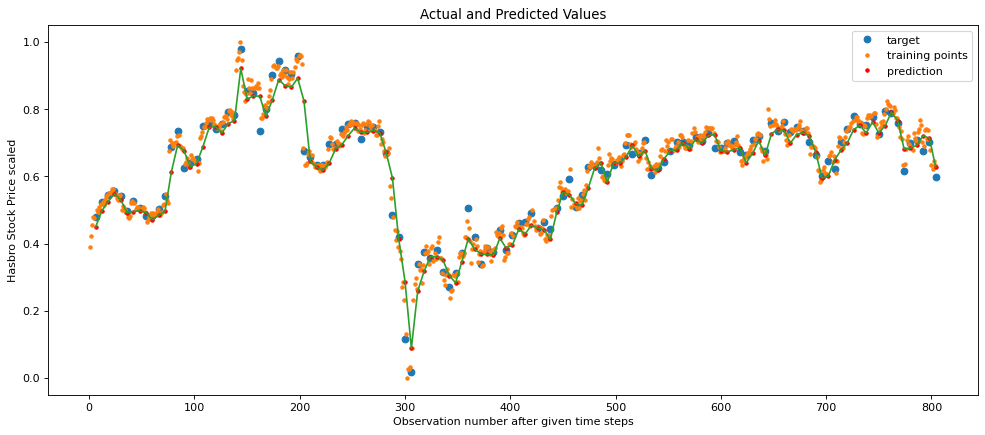

In [20]:
modelProcess(model_name = "lstm", 
             dropout = None, 
             regularization = None, 
             verbose=0)

# 6) LSTM w/ Regularization


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 3)                 60        
                                                                 
 dense_5 (Dense)             (None, 1)                 4         
                                                                 
Total params: 64
Trainable params: 64
Non-trainable params: 0
_________________________________________________________________


2023-04-23 23:06:02.705767: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-23 23:06:02.707150: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-23 23:06:02.708303: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2023-04-23 23:06:02.981124: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-23 23:06:02.982885: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-23 23:06:02.984277: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus


5/5 [==============================] - 0s 2ms/step


2023-04-23 23:06:12.572837: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-23 23:06:12.574416: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-23 23:06:12.575869: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2/2 [==============================] - 0s 3ms/step
Train MSE = 0.00148 RMSE = 0.03851
Test MSE = 0.00107 RMSE = 0.03263

2/2 [==============================] - 0s 3ms/step
(670,) (134,)


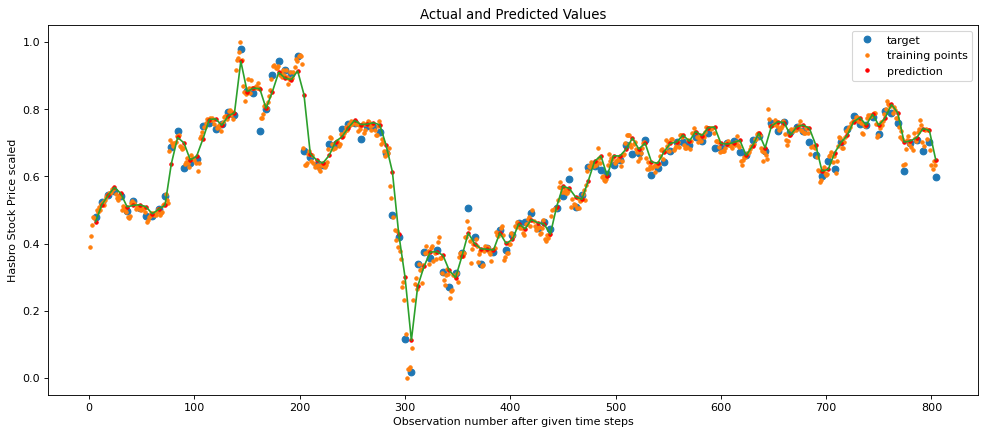

In [21]:
modelProcess(model_name = "lstm", 
             dropout = None, 
             regularization = regularizers.L2(1e-2), 
             verbose=0)